In [11]:
import random
import networkx as nx
import numpy as np
import time

from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer, get_benchmarker
from pyquil.gates import CNOT, CCNOT, Z, X, I, H, CZ, MEASURE, RESET
from pyquil.quilbase import Pragma

from forest.benchmarking.volumetrics import *
from pyquil import *
# if you want to run on a "real lattice"
#list_quantum_computers()
#perfect_qc = get_qc("Aspen-1-16Q-A", as_qvm=True, noisy=False)
#noisy_qc = get_qc("Aspen-1-16Q-A") #, as_qvm=True, noisy=True)

noisy_qc = get_qc("9q-square-qvm", as_qvm=True, noisy=True)
ideal_qc = get_qc("9q-square-qvm", as_qvm=True, noisy=False)
pyqvm = get_qc('9q-pyqvm')

bm = get_benchmarker()

In [2]:
def two_q_id(qb1,qb2):
    prog = Program()
    prog +=I(qb1)
    prog +=I(qb2)
    return prog

one_c_gates = [X,I]
two_c_gates = [two_q_id, CNOT]
two_c_toffoli = two_c_gates + [CCNOT]

# x basis gates
from forest.benchmarking.classical_logic import CNOT_X_basis, CCNOT_X_basis
one_x_c_gates = [Z, I]
two_x_c_gates = [two_q_id, CNOT_X_basis]
two_x_c_toffoli = two_x_c_gates + [CCNOT_X_basis]

one_q_gates = [X,Z,I]
two_q_gates = [two_q_id,CZ]

In [3]:
classical_1q_layer = get_rand_1q_template(one_c_gates)
classical_2q_layer = get_rand_2q_template(two_c_gates)
classical_1q_2q = classical_1q_layer + classical_2q_layer


# classical in x basis
classical_x_1q_2q = get_rand_1q_template(one_x_c_gates) + get_rand_2q_template(two_x_c_gates)
classical_x_1q_2q.sequence_transforms.append(hadamard_sandwich)


clifford_1q_layer = get_rand_1q_cliff_template(bm)
clifford_2q_layer = get_rand_2q_cliff_template(bm)
clifford_sandwich = clifford_1q_layer + clifford_2q_layer
clifford_sandwich.sequence_transforms.append(dagger_sequence)

qv_template = get_quantum_volume_template()


def uniform_random_graph(n):
    return nx.erdos_renyi_graph(n, 1/2)

qaoa_template = get_maxcut_qaoa_template(uniform_random_graph)

In [4]:
widths = [2,3,4]
depths = [2,3,4]
dimensions = {w: [d for d in depths] for w in widths}
num_shots = 250
ckt_family = classical_1q_2q

prog_array = generate_volumetric_program_array(noisy_qc, ckt_family, dimensions, num_circuit_samples=100)

In [5]:
expt_data_array = acquire_volumetric_data(noisy_qc, prog_array, num_shots=num_shots)

KeyboardInterrupt: 

In [ ]:
ideal_data_array = acquire_volumetric_data(pyqvm, prog_array, num_shots=1)

In [ ]:
succ_probs = get_single_target_success_probabilities(expt_data_array, ideal_data_array)
threshold = 3/4 # this happens to be interesting for default qvm noise model
successes = determine_successes(succ_probs, num_shots_per_ckt=num_shots, success_threshold=threshold)
plot_success(successes, f'Confident > {threshold}')

In [8]:
print(determine_prob_success_lower_bounds(succ_probs, num_shots))

{2: {2: 0.825874178895398, 3: 0.8171815818094001, 4: 0.811804500154355}, 3: {2: 0.7740486147049136, 3: 0.7646885997416862, 4: 0.7626539548048714}, 4: {2: 0.696878315075042, 3: 0.6978774020707421, 4: 0.7026533406446034}}


In [9]:
def get_success_probs(ckt_family, widths, depths, num_ckt_samples=100, num_shots=500):
    dimensions = {w: [d for d in depths] for w in widths}
    prog_array = generate_volumetric_program_array(noisy_qc, ckt_family, dimensions, num_circuit_samples=num_ckt_samples)
    expt_data_array = acquire_volumetric_data(noisy_qc, prog_array, num_shots=num_shots)
    ideal_data_array = acquire_volumetric_data(pyqvm, prog_array, num_shots=1)
    return get_single_target_success_probabilities(expt_data_array, ideal_data_array)

def probs_to_plot(success_probabilities, num_shots, threshold, ckt_family_name=""):
    successes = determine_successes(succ_probs, num_shots_per_ckt=num_shots, success_threshold=threshold)
    plot_success(successes, ckt_family_name + f' Confident > {threshold}')

In [10]:
from typing import Tuple, Sequence, Callable, Dict, List, Union, Optional
from pyquil.quil import Program
from pyquil.api import QuantumComputer
from pyquil.gates import MEASURE, RESET

def acquire_paramterized_volumetric_data(qc: QuantumComputer, 
                                         program_array: Dict[int, Dict[int, List[Program]]],
                                         num_shots: int = 500,
                                         measure_qubits: Dict[int,  Dict[int, List[int]]] = None,
                                         use_active_reset:  bool = False, use_compiler: bool = False,
                                        memory_map = None) \
        -> Dict[int, Dict[int, List[np.ndarray]]]:
    """
    Runs each program in `program_array` on the qc and stores the results, organized again by
    width and depth.

    :param qc:
    :param program_array:
    :param num_shots:
    :param measure_qubits:
    :param use_active_reset:
    :param use_compiler:
    :return:
    """
    reset_prog = Program()
    if use_active_reset:
        reset_prog += RESET()

    results = {width: {depth: [] for depth in depth_array.keys()}
               for width, depth_array in program_array.items()}

    for width, depth_array in program_array.items():
        for depth, prog_list in depth_array.items():
            for idx, program in enumerate(prog_list):
                prog = program.copy()

                if measure_qubits is not None:
                    qubits = measure_qubits[width][depth][idx]
                else:
                    qubits = sorted(list(program.get_qubits()))

                ro = prog.declare('ro', 'BIT', len(qubits))
                for idx, q in enumerate(qubits):
                    prog += MEASURE(q, ro[idx])

                prog.wrap_in_numshots_loop(num_shots)

                if use_compiler:
                    prog = qc.compiler.quil_to_native_quil(prog)

                exe = qc.compiler.native_quil_to_executable(prog)
                if memory_map is None:
                    shots = qc.run(exe)
                else:
                shots = qc.run(exe, memory_map=)
                results[width][depth].append(shots)

    return results

IndentationError: expected an indented block (<ipython-input-10-70225dac26a7>, line 55)

In [11]:
widths = [2,3,4]
depths = [2,3,4]
dimensions = {w: [d for d in depths] for w in widths}
num_shots = 5
ckt_family = qaoa_template
prog_array = generate_volumetric_program_array(noisy_qc, ckt_family, dimensions, num_circuit_samples=100)
expt_data_array = acquire_volumetric_data(noisy_qc, prog_array, num_shots=num_shots)

RPCError: User program used too many qubits: 4 used and 2 available in the largest connected component.

In [6]:
def evaluate_cut_value(graph, partition):
    value = 0
    for edge in graph.edges():
        value += (partition[edge[0]] + partition[edge[1]]) % 2
    return value


# def expected_erdos_renyi_random_cut_value(n, p=1/2):
#     return n * (n - 1) * p / 4

def max_fixed_cut_erdos_renyi_expected_cut_value(n, p=1/2):
    half = n // 2
    other_half = (n - half)
    return half * other_half * p
    
    
def get_most_frequent_result(bitstrings):
    bitstring_tuples = list(map(tuple, bitstring_samples))
    freq = Counter(bitstring_tuples)
    most_frequent_bit_string = max(freq, key=lambda x: freq[x])


# average = 0
# samples = 10000
# n = 21
# for _ in range(samples):
#     cut = np.random.randint(2, size=(n,))
#     average += evaluate_cut_value(uniform_random_graph(n), [0,1]*10 + [0])/samples
# print(average)
# print(max_fixed_cut_erdos_renyi_expected_cut_value(n))
# print(n**2/8)

In [7]:
run_single_parameterized_program(qc: QuantumComputer,
                                 program,
                                 num_shots: int = 500,
                                 measure_qubits: List[int] = None,
                                 use_active_reset:  bool = False, use_compiler: bool = False,
                                 memory_map = None) 
    reset_prog = Program()
    if use_active_reset:
        reset_prog += RESET()
    prog = program.copy()

    if measure_qubits is not None:
        qubits = measure_qubits
    else:
        qubits = sorted(list(program.get_qubits()))

    ro = prog.declare('ro', 'BIT', len(qubits))
    for idx, q in enumerate(qubits):
        prog += MEASURE(q, ro[idx])

    prog.wrap_in_numshots_loop(num_shots)

    if use_compiler:
        prog = qc.compiler.quil_to_native_quil(prog)

    exe = qc.compiler.native_quil_to_executable(prog)
    if memory_map is None:
        shots = qc.run(exe)
    else:
        shots = qc.run(exe, memory_map=)
    results[width][depth].append(shots)

SyntaxError: invalid syntax (<ipython-input-7-7ce8606810b2>, line 1)

In [42]:
from pyquil.paulis import sI, PauliTerm
from pyquil.quil import merge_programs
from forest.benchmarking.compilation import basic_compile

def pauli_prog_to_pauli_term(prog):
    pauli = sI()
    for gate in prog:
        pauli *= PauliTerm(gate.name, gate.qubits[0].index)
    return pauli
        
def compute_conjugated_pauli(sequence, bm):
    """
    Assumes sequence is like P C P C ... C P C^t ... C^t P C^t P
    """
    assert len(sequence) % 2 == 1
    middle_idx = len(sequence)//2
    first_half = sequence[:middle_idx]
    init_pauli = sequence[middle_idx]
    last_half = sequence[middle_idx + 1:]
    
    pauli = pauli_prog_to_pauli_term(init_pauli)
    for idx, (left, right) in enumerate(zip(reversed(first_half), last_half)):
        if idx % 2 == 0:
            # bm returns the operator CPC^t, where C^t is applied first. 
            # Since in our situation C (i.e. `left`) is applied first, we want to conjugate by C^t
            pauli = bm.apply_clifford_to_pauli(right, pauli)
        else:
            pauli = pauli_prog_to_pauli_term(right) * pauli *  pauli_prog_to_pauli_term(left)
    return pauli.program

def get_append_conjugated_pauli_transform(bm):
    def transform(sequence, **kwargs):
        return sequence + [compute_conjugated_pauli(sequence, bm)]
    return transform

def basic_compile_sequence(sequence, **kwargs):
    merged = merge_programs(sequence)
    return [basic_compile(merged)]

clifford_pauli_randomized = get_rand_2q_cliff_template(bm)
clifford_pauli_randomized.sequence_transforms.append(dagger_sequence)
clifford_pauli_randomized.sequence_transforms.append(pauli_frame_randomize_sequence)
clifford_pauli_randomized.sequence_transforms.append(get_append_conjugated_pauli_transform(bm))
clifford_pauli_randomized.sequence_transforms.append(basic_compile_sequence)

In [43]:
widths = [2,3,4]
depths = [2,3,4]
dimensions = {w: [d for d in depths] for w in widths}
num_shots = 250
num_ckt_samples = 100
ckt_family = clifford_pauli_randomized

prog_array = generate_volumetric_program_array(noisy_qc, ckt_family, dimensions, num_circuit_samples=num_ckt_samples)

In [50]:
ideal_data_array = {w: {d: [np.zeros((1,w)) for _ in range(num_ckt_samples)] for d in depths} for w, depths in prog_array.items()}

{2: {2: [array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), array([[0., 0.]]), arr

In [45]:
from forest.benchmarking.compilation import basic_compile
expt_data_array = acquire_volumetric_data(noisy_qc, 
                                          {w: 
                                           {d: 
                                            [basic_compile(prog) for prog in prog_list] 
                                            for d, prog_list in w_dict.items()}
                                          for w, w_dict in prog_array.items()}, 
                                          num_shots=num_shots)

(<Figure size 216x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa2115e30b8>)

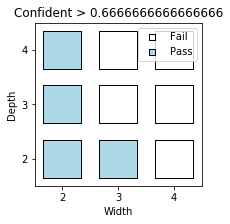

In [51]:
succ_probs = get_single_target_success_probabilities(expt_data_array, ideal_data_array)
threshold = 2/3 # this happens to be interesting for default qvm noise model
successes = determine_successes(succ_probs, num_shots_per_ckt=num_shots, success_threshold=threshold)
plot_success(successes, f'Confident > {threshold}')